### **Dataset Overview**

Your dataset `ECGData.mat` contains:

- **Signals**: A 162x65536 matrix where each row represents an ECG signal of length 65,536 samples.
- **Labels**: A 162x1 cell array containing labels for each signal.
- **Labels Meaning**:
    - `'ARR'`: Arrhythmia (from MIT-BIH Arrhythmia Database)
    - `'CHF'`: Congestive Heart Failure (from BIDMC Congestive Heart Failure Database)
    - `'NSR'`: Normal Sinus Rhythm (from MIT-BIH Normal Sinus Rhythm Database)
- **Sampling Rate**: All signals have been resampled to **128 Hz**.
- **Signal Length**: Each signal is **65536 samples long**, corresponding to approximately 8.5 minutes of data (since 65536 samples / 128 Hz ≈ 512 seconds).

# 1. Imports and Data Loading

In this first step, we import all the necessary libraries and load our ECG data from the `.mat` file.
- **NumPy** and **Pandas** for data manipulation.
- **Matplotlib** for visualization.
- **Scikit-learn** modules for train/test splitting and label encoding.
- **TensorFlow** (Keras) for building our neural network models.

We then:
1. Extract the `Signals` and `Labels` from the loaded dataset.
2. Map the labels (e.g., 'NSR' -> 'N', 'ARR'/'CHF' -> 'A', etc.).
3. Encode those labels into integers (0, 1).
4. Standardize each ECG signal (subtract mean, divide by std).

Afterward, we display the shapes to confirm we loaded everything correctly.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -- LOADING ECG DATA --
data = loadmat('ECGData.mat')
ecg_data = data['ECGData']
ecg_data_item = ecg_data[0, 0]

Signals = ecg_data_item['Data']        # shape: (162, 65536) 
Labels_array = ecg_data_item['Labels'] # shape: (162, 1)

# Convert labels to a list of strings
Labels = [Labels_array[i, 0][0] for i in range(Labels_array.shape[0])]

# Map labels: ('NSR' -> 'N'; 'ARR'/'CHF' -> 'A'; else -> 'Other')
Labels_mapped = []
for label in Labels:
    if label == 'NSR':
        Labels_mapped.append('N')
    elif label in ['ARR', 'CHF']:
        Labels_mapped.append('A')
    else:
        Labels_mapped.append('Other')
Labels_mapped = np.array(Labels_mapped)

# Encode labels: N->0, A->1, Other->2 (if it appears)
le = LabelEncoder()
raw_labels_encoded = le.fit_transform(Labels_mapped)

# Standardize signals
Signals_normalized = []
for signal in Signals:
    signal = signal.astype(np.float32)
    mean_val = np.mean(signal)
    std_val = np.std(signal) if np.std(signal) > 1e-6 else 1e-6
    signal = (signal - mean_val) / std_val
    Signals_normalized.append(signal)
Signals_normalized = np.array(Signals_normalized)

print("Signals shape:", Signals_normalized.shape)
print("Labels shape:", raw_labels_encoded.shape)


Signals shape: (162, 65536)
Labels shape: (162,)


# 2. Segmentation Function

Often, ECG signals are too long for direct input into our models. We can improve 
training by segmenting each signal into shorter windows.

Below is a `segment_signals` function:
- **Parameters**:
  - `signals`: N x M array (N signals, each with M samples).
  - `labels`: N-dimensional array with the label for each signal.
  - `sample_time_size`: how many seconds per segment.
  - `step_size`: overlap in samples between consecutive windows (default: no overlap).
  - `fs`: sampling frequency (default 128 Hz).
  
- **Returns**:
  - `X_segments`: shape (total_segments, window_size), each row is a segment.
  - `Y_segments`: shape (total_segments, ), labels repeating for each segment of a given signal.


In [32]:
def segment_signals(signals, labels, sample_time_size=5, step_size=None, fs=128):
    """
    Segment each long ECG signal into smaller windows of length (fs * sample_time_size).
    
    signals           : np.ndarray of shape (n_signals, n_samples_per_signal)
    labels            : np.ndarray of shape (n_signals,) integer labels
    sample_time_size  : int, number of seconds per segment
    step_size         : int or None, overlap in samples between segments (default: no overlap)
    fs                : int, sampling frequency (Hz)
    
    returns
    -------
    X_segments : np.ndarray of shape (total_segments, window_size)
    Y_segments : np.ndarray of shape (total_segments,)
    """
    window_size = fs * sample_time_size
    step_size = step_size or window_size
    
    segs, seg_labels = [], []
    for i in range(len(signals)):
        sig = signals[i]
        lbl = labels[i]
        
        if len(sig) < window_size:
            # If a signal is too short, we skip it
            continue
        
        for start in range(0, len(sig) - window_size + 1, step_size):
            segment = sig[start : start + window_size]
            segs.append(segment)
            seg_labels.append(lbl)
    
    return np.array(segs), np.array(seg_labels)


# 3. Apply Segmentation + Visualization

We now apply the segmentation function to the normalized signals. 
- **sample_time_size=5** means 5-second windows (if fs=128 Hz -> each window is 640 samples).
- We then display the shapes to confirm how many segments were created.

We also plot a small portion (first 500 samples) of the first segment, to visualize 
what an individual window looks like in time-domain.


Segmented X shape: (16524, 640)
Segmented Y shape: (16524,)


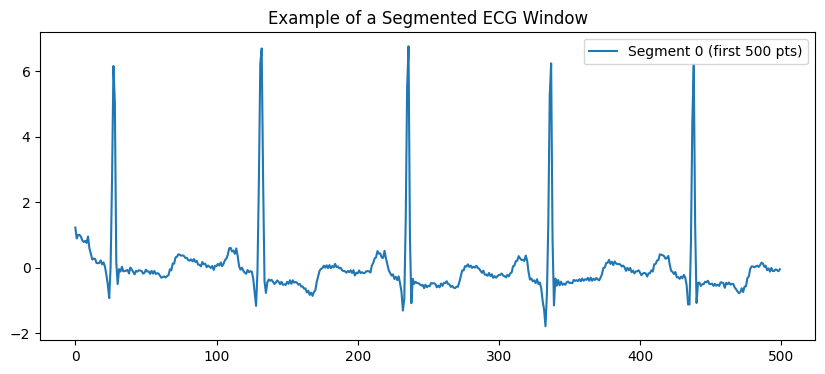

In [33]:
# Segment the signals into 5-second windows (no overlap)
X_segments, Y_segments = segment_signals(Signals_normalized, raw_labels_encoded, 
                                         sample_time_size=5, step_size=None, fs=128)

print("Segmented X shape:", X_segments.shape)
print("Segmented Y shape:", Y_segments.shape)

# OPTIONAL: Visualize the first 500 samples of the first segment
plt.figure(figsize=(10, 4))
plt.plot(X_segments[0][:500], label='Segment 0 (first 500 pts)')
plt.title("Example of a Segmented ECG Window")
plt.legend()
plt.show()


# 4. Noise Functions

To simulate real-world conditions, we introduce functions that add different 
types of noise to each segment. 

1. **Gaussian Noise**: Normal distribution with a given standard deviation.
2. **Uniform Noise**: Values uniformly drawn from [-noise_level, noise_level].
3. **Exponential Noise**: Positively skewed distribution, controlled by 'scale'.

We also include a quick demonstration of adding noise to a single segmented 
window, so you can see the effect visually.


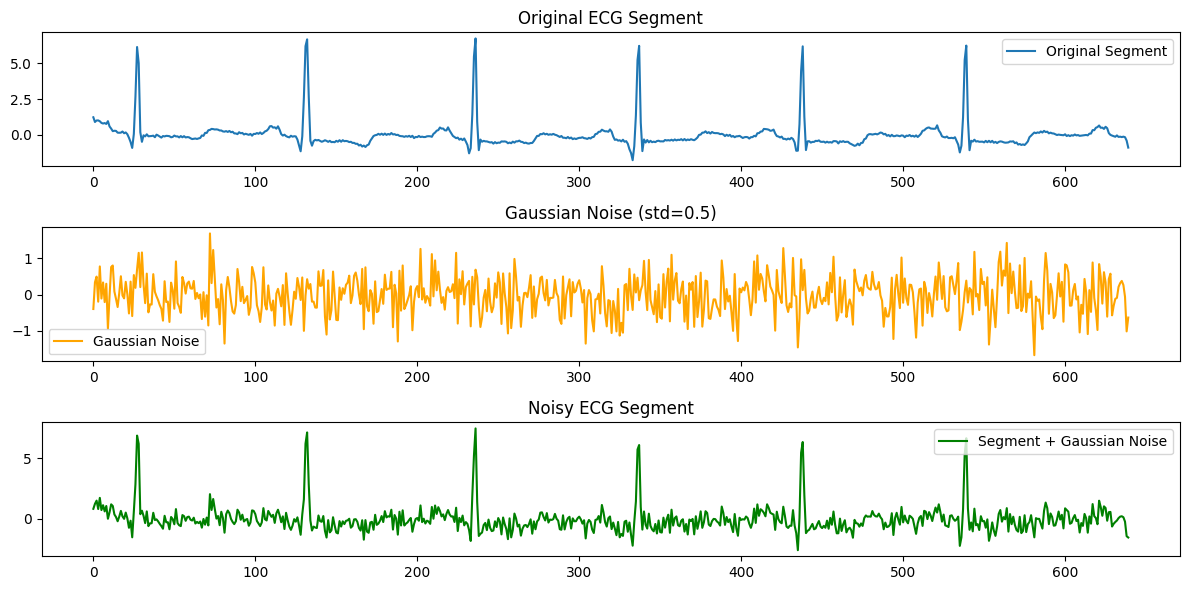

In [34]:
def add_gaussian_noise(signal, noise_level=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=signal.shape)
    noisy_signal = signal + noise
    return noisy_signal, noise

def add_uniform_noise(signal, noise_level=0.1):
    noise = np.random.uniform(low=-noise_level, high=noise_level, size=signal.shape)
    noisy_signal = signal + noise
    return noisy_signal, noise

def add_exponential_noise(signal, noise_level=0.1):
    noise = np.random.exponential(scale=noise_level, size=signal.shape)
    noisy_signal = signal + noise
    return noisy_signal, noise

# Demo on a single segment
idx = 0
sample_segment = X_segments[idx][:1000]  # first 1000 samples
noise_level = 0.5
noisy_segment_gauss, noise_gauss = add_gaussian_noise(sample_segment, noise_level=noise_level)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(sample_segment, label='Original Segment')
plt.title("Original ECG Segment")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(noise_gauss, color='orange', label='Gaussian Noise')
plt.title(f"Gaussian Noise (std=0.5)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(noisy_segment_gauss, color='green', label='Segment + Gaussian Noise')
plt.title("Noisy ECG Segment")
plt.legend()
plt.tight_layout()
plt.show()


# 5. Precompute Noisy Datasets for Each Noise Level

We choose a set of noise levels, e.g., `[0.05, 0.2, 0.5]`, and create **noisy versions** 
of our entire **segmented** dataset under each noise level. We store them in a dictionary 
`noisy_datasets`, keyed by the noise level. This saves time so we don’t have to regenerate 
noise for every training experiment.


In [35]:
noise_levels = [0.05, 0.2, 0.5]
noisy_datasets = {}

print("Precomputing noisy datasets (on segmented signals)...")
for nl in noise_levels:
    noisy_segments_list = []
    for seg in X_segments:
        noisy_seg, _ = add_gaussian_noise(seg, noise_level=nl)
        noisy_segments_list.append(noisy_seg)
    noisy_segments_array = np.array(noisy_segments_list)
    noisy_datasets[nl] = noisy_segments_array
print("Precomputation done!")


Precomputing noisy datasets (on segmented signals)...
Precomputation done!


# 6. Training Functions: SimpleRNN & LSTM

We define two functions for training and evaluating:
1. `train_evaluate_rnn`: Builds a SimpleRNN-based model for binary classification.
2. `train_evaluate_lstm`: Builds an LSTM-based model for binary classification.

Both:
- Compile with `Adam` optimizer (LR=0.01), `binary_crossentropy`, and `accuracy`.
- Fit on (X_train, y_train) and validate on (X_test, y_test).
- Return the final test accuracy after evaluation.


In [36]:
def train_evaluate_rnn(X_train_3d, X_test_3d, y_train, y_test,
                       units=64, epochs=5, batch_size=128):
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_3d, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_test_3d, y_test),
              callbacks=[early_stop],
              verbose=1)

    loss, acc = model.evaluate(X_test_3d, y_test, verbose=1)
    return acc, model  # return both

def train_evaluate_lstm(X_train_3d, X_test_3d, y_train, y_test,
                        units=64, epochs=5, batch_size=128):
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_3d, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_test_3d, y_test),
              callbacks=[early_stop],
              verbose=1)

    loss, acc = model.evaluate(X_test_3d, y_test, verbose=1)
    return acc, model  # return both


# 7. Train RNN Across All Noise Levels (Using Segmented Data)

Using our `noisy_datasets`, we:
1. Retrieve the noisy dataset
2. Split into train/test
3. Reshape for RNN
4. Call `train_evaluate_rnn` => get (accuracy, model)
5. Store the accuracy in `rnn_results` and the model in `rnn_models`.

We repeat this for each noise level and store results in `rnn_results`.


In [37]:
rnn_results = []
rnn_models = {}  # to store the final RNN model for each noise level

print("\n=== RNN Experiments (Segmented Data) ===")

for nl in noise_levels:
    print(f"\n[Noise Level: {nl}]")
    
    noisy_segments = noisy_datasets[nl]
    X_train, X_test, y_train, y_test = train_test_split(
        noisy_segments, Y_segments,
        test_size=0.2, random_state=42, stratify=Y_segments
    )
    X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_3d  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    rnn_acc, rnn_model = train_evaluate_rnn(X_train_3d, X_test_3d, y_train, y_test,
                                            units=64, epochs=10, batch_size=128)
    rnn_results.append(rnn_acc)
    rnn_models[nl] = rnn_model  # store the trained model
    
    print(f"RNN Accuracy at noise={nl}: {rnn_acc:.4f}")



=== RNN Experiments (Segmented Data) ===

[Noise Level: 0.05]
Epoch 1/10


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6909 - loss: 0.5973 - val_accuracy: 0.7389 - val_loss: 0.6003
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7742 - loss: 0.5463 - val_accuracy: 0.7779 - val_loss: 0.5331
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7789 - loss: 0.5317 - val_accuracy: 0.7779 - val_loss: 0.5320
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7781 - loss: 0.5340 - val_accuracy: 0.7779 - val_loss: 0.5323
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7818 - loss: 0.5300 - val_accuracy: 0.7779 - val_loss: 0.5459
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7765 - loss: 0.5339
RNN Accuracy at noise=0.05: 0.7779

[Noise Level: 0.2]
Epoch 1/10


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6950 - loss: 0.6183 - val_accuracy: 0.7779 - val_loss: 0.5454
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7819 - loss: 0.5365 - val_accuracy: 0.7779 - val_loss: 0.5298
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7752 - loss: 0.5329 - val_accuracy: 0.7779 - val_loss: 0.5276
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7797 - loss: 0.5346 - val_accuracy: 0.7779 - val_loss: 0.5327
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7767 - loss: 0.5321 - val_accuracy: 0.7779 - val_loss: 0.5324
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7765 - loss: 0.5289
RNN Accuracy at noise=0.2: 0.7779

[Noise Level: 0.5]
Epoch 1/10


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7187 - loss: 0.5820 - val_accuracy: 0.6487 - val_loss: 0.6021
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7512 - loss: 0.5575 - val_accuracy: 0.7670 - val_loss: 0.5345
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7710 - loss: 0.5373 - val_accuracy: 0.7694 - val_loss: 0.5346
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7790 - loss: 0.5303 - val_accuracy: 0.7779 - val_loss: 0.5388
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7646 - loss: 0.5370
RNN Accuracy at noise=0.5: 0.7670


# 8. Train LSTM Across All Noise Levels (Using Segmented Data)

Same process as above, but using our LSTM model. We again:
1. Pick each noise level.
2. Load the corresponding noisy segments.
3. Train/test split.
4. Reshape to (samples, timesteps, 1).
5. Train LSTM, evaluate on the test set, and track final accuracy.

Results are stored in `lstm_results`.


In [38]:
lstm_results = []
lstm_models = {}
print("\n=== LSTM Experiments (Segmented Data) ===")

for nl in noise_levels:
    print(f"\n[Noise Level: {nl}]")
    
    noisy_segments = noisy_datasets[nl]
    X_train, X_test, y_train, y_test = train_test_split(
        noisy_segments, Y_segments,
        test_size=0.2, random_state=42, stratify=Y_segments
    )
    X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_3d  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    lstm_acc, lstm_model = train_evaluate_lstm(X_train_3d, X_test_3d, y_train, y_test,
                                               units=64, epochs=5, batch_size=128)
    lstm_results.append(lstm_acc)
    lstm_models[nl] = lstm_model
    
    print(f"LSTM Accuracy at noise={nl}: {lstm_acc:.4f}")



=== LSTM Experiments (Segmented Data) ===

[Noise Level: 0.05]
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.7645 - loss: 0.5442 - val_accuracy: 0.8215 - val_loss: 0.4503
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.7939 - loss: 0.4762 - val_accuracy: 0.7782 - val_loss: 0.5319
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 243ms/step - accuracy: 0.7876 - loss: 0.5190 - val_accuracy: 0.7779 - val_loss: 0.5263
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8229 - loss: 0.4482
LSTM Accuracy at noise=0.05: 0.8215

[Noise Level: 0.2]
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.7698 - loss: 0.5466 - val_accuracy: 0.7779 - val_loss: 0.5242
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 244ms/step - accuracy: 0.7799 - loss: 0.5140 - val_accuracy: 0.7779 - val_loss: 0.5067
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step - accuracy: 0.7838 - loss: 0.5203 - val_accuracy: 0.7770 - val_loss: 0.5186
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.7914 - loss: 0.4790 - val_accuracy: 0.7794 - val_loss: 0.4262
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - accuracy: 0.8351 - loss: 0.3751 - val_accuracy: 0.8702 - val_loss: 0.3234
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8749 - loss: 0.3157
LSTM Accuracy at noise=0.2: 0.8702

[Noise Level: 0.5]
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.7606 - loss: 0.5366 - val_accuracy: 0.7779 - val_loss: 0.5286
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - accuracy: 0.7750 - loss: 0.5348 - val_accuracy: 0.7779 - val_loss: 0.5156
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step - accuracy: 0.7780 - loss: 0.5150 - val_accuracy: 0.7779 - val_loss: 0.4850
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - accuracy: 0.7917 - loss: 0.4359 - val_accuracy: 0.7779 - val_loss: 0.4858
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 240ms/step - accuracy: 0.7847 - loss: 0.4517 - val_accuracy: 0.8460 - val_loss: 0.3456
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8591 - loss: 0.3374
LSTM Accuracy at noise=0.5: 0.8460


# 9. Final Results Summary

We display a concise table of accuracies for each noise level, comparing 
SimpleRNN and LSTM performance. This helps us quickly gauge how each 
model handles increasing noise when using segmented data.


In [39]:
print("\n=== Final Summary of Results for Noise (Segmented) ===")
for i, nl in enumerate(noise_levels):
    print(f"Noise Level: {nl}"
          f" | RNN Acc: {rnn_results[i]:.4f}"
          f" | LSTM Acc: {lstm_results[i]:.4f}")



=== Final Summary of Results for Noise (Segmented) ===
Noise Level: 0.05 | RNN Acc: 0.7779 | LSTM Acc: 0.8215
Noise Level: 0.2 | RNN Acc: 0.7779 | LSTM Acc: 0.8702
Noise Level: 0.5 | RNN Acc: 0.7670 | LSTM Acc: 0.8460


# 10. Detailed Evaluation (Confusion Matrix, Classification Report, ROC)

Now that we have `rnn_models` and `lstm_models` stored, we can pick any noise level, 
load the corresponding model and test set, and generate:
1. Confusion Matrix
2. Classification Report (precision, recall, F1)
3. ROC Curve with AUC

Below is an example for a single scenario (RNN at noise=0.5). You can repeat 
for any noise level or switch `rnn_models` to `lstm_models`.


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
 [[2523   48]
 [ 722   12]]

Classification Report:
              precision    recall  f1-score   support

 Abnormal(0)       0.78      0.98      0.87      2571
   Normal(1)       0.20      0.02      0.03       734

    accuracy                           0.77      3305
   macro avg       0.49      0.50      0.45      3305
weighted avg       0.65      0.77      0.68      3305



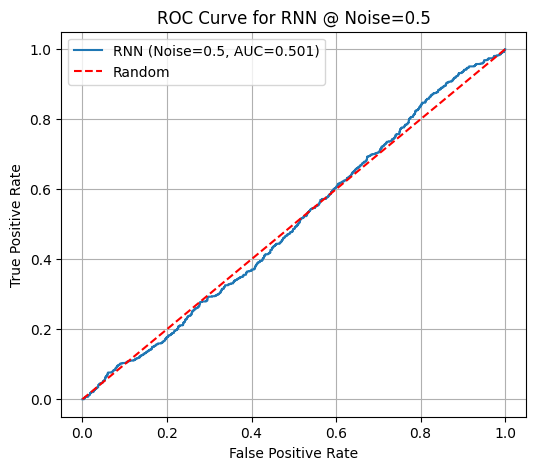

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Evaluate the RNN model at noise=0.5
nl = 0.5

# the model stored as:
model_rnn_05 = rnn_models[nl]

# Re-create the test set for that noise level
noisy_segments = noisy_datasets[nl]
X_train, X_test, y_train, y_test = train_test_split(
    noisy_segments, Y_segments,
    test_size=0.2, random_state=42, stratify=Y_segments
)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1) Predictions (probabilities and binary labels)
y_pred_probs = model_rnn_05.predict(X_test_3d).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3) Classification Report
#   Note the corrected order: 0 -> "Abnormal", 1 -> "Normal"
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=["Abnormal(0)", "Normal(1)"]))

# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (Noise={nl}, AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'r--', label="Random")
plt.title("ROC Curve for RNN @ Noise=0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
 [[2571    0]
 [ 734    0]]

Classification Report:
              precision    recall  f1-score   support

 Abnormal(0)       0.78      1.00      0.88      2571
   Normal(1)       0.00      0.00      0.00       734

    accuracy                           0.78      3305
   macro avg       0.39      0.50      0.44      3305
weighted avg       0.61      0.78      0.68      3305



/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

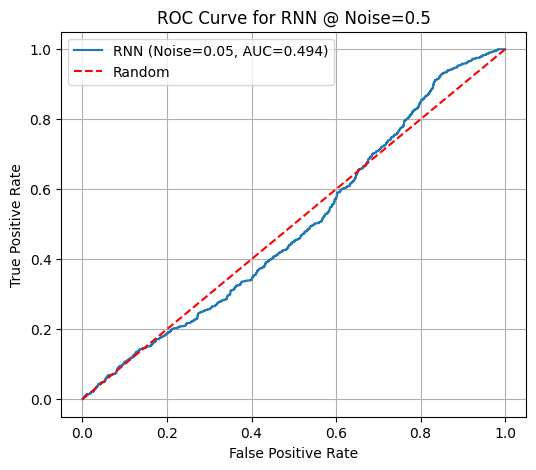

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Evaluate the RNN model at noise=0.5
nl = 0.05

# the model stored as:
model_rnn_05 = rnn_models[nl]

# Re-create the test set for that noise level
noisy_segments = noisy_datasets[nl]
X_train, X_test, y_train, y_test = train_test_split(
    noisy_segments, Y_segments,
    test_size=0.2, random_state=42, stratify=Y_segments
)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1) Predictions (probabilities and binary labels)
y_pred_probs = model_rnn_05.predict(X_test_3d).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3) Classification Report
#   Note the corrected order: 0 -> "Abnormal", 1 -> "Normal"
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=["Abnormal(0)", "Normal(1)"]))

# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (Noise={nl}, AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'r--', label="Random")
plt.title("ROC Curve for RNN @ Noise=0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Confusion Matrix:
 [[2414  157]
 [ 352  382]]

Classification Report:
              precision    recall  f1-score   support

 Abnormal(0)       0.87      0.94      0.90      2571
   Normal(1)       0.71      0.52      0.60       734

    accuracy                           0.85      3305
   macro avg       0.79      0.73      0.75      3305
weighted avg       0.84      0.85      0.84      3305



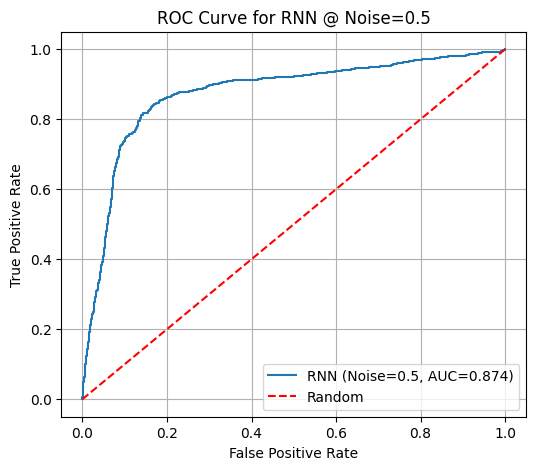

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Evaluate the RNN model at noise=0.5
nl = 0.5

# Suppose we have the model stored as:
model_rnn_05 = lstm_models[nl]

# Re-create the test set for that noise level
noisy_segments = noisy_datasets[nl]
X_train, X_test, y_train, y_test = train_test_split(
    noisy_segments, Y_segments,
    test_size=0.2, random_state=42, stratify=Y_segments
)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1) Predictions (probabilities and binary labels)
y_pred_probs = model_rnn_05.predict(X_test_3d).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3) Classification Report
#   Note the corrected order: 0 -> "Abnormal", 1 -> "Normal"
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=["Abnormal(0)", "Normal(1)"]))

# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (Noise={nl}, AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'r--', label="Random")
plt.title("ROC Curve for RNN @ Noise=0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Confusion Matrix:
 [[2333  238]
 [ 352  382]]

Classification Report:
              precision    recall  f1-score   support

 Abnormal(0)       0.87      0.91      0.89      2571
   Normal(1)       0.62      0.52      0.56       734

    accuracy                           0.82      3305
   macro avg       0.74      0.71      0.73      3305
weighted avg       0.81      0.82      0.82      3305



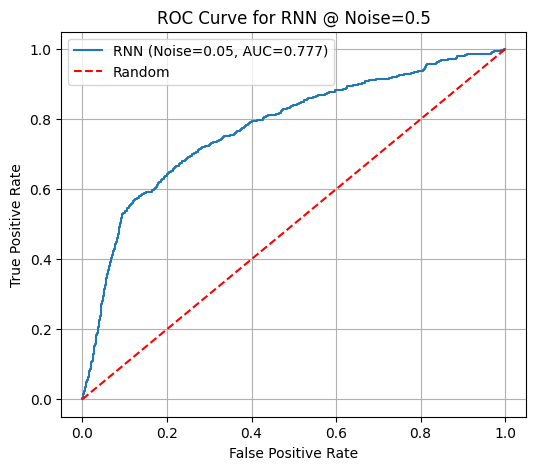

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Evaluate the RNN model at noise=0.5
nl = 0.05

# Suppose we have the model stored as:
model_rnn_05 = lstm_models[nl]

# Re-create the test set for that noise level
noisy_segments = noisy_datasets[nl]
X_train, X_test, y_train, y_test = train_test_split(
    noisy_segments, Y_segments,
    test_size=0.2, random_state=42, stratify=Y_segments
)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1) Predictions (probabilities and binary labels)
y_pred_probs = model_rnn_05.predict(X_test_3d).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3) Classification Report
#   Note the corrected order: 0 -> "Abnormal", 1 -> "Normal"
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=["Abnormal(0)", "Normal(1)"]))

# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (Noise={nl}, AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'r--', label="Random")
plt.title("ROC Curve for RNN @ Noise=0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Confusion Matrix:
 [[2356  215]
 [ 214  520]]

Classification Report:
              precision    recall  f1-score   support

 Abnormal(0)       0.92      0.92      0.92      2571
   Normal(1)       0.71      0.71      0.71       734

    accuracy                           0.87      3305
   macro avg       0.81      0.81      0.81      3305
weighted avg       0.87      0.87      0.87      3305



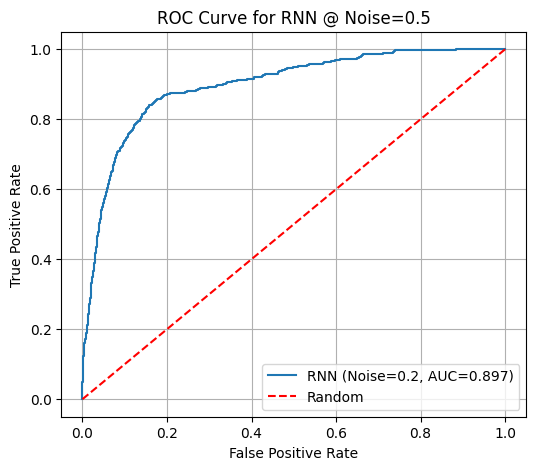

In [48]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Evaluate the RNN model at noise=0.5
nl = 0.2

# Suppose we have the model stored as:
model_rnn_05 = lstm_models[nl]

# Re-create the test set for that noise level
noisy_segments = noisy_datasets[nl]
X_train, X_test, y_train, y_test = train_test_split(
    noisy_segments, Y_segments,
    test_size=0.2, random_state=42, stratify=Y_segments
)
X_test_3d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1) Predictions (probabilities and binary labels)
y_pred_probs = model_rnn_05.predict(X_test_3d).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3) Classification Report
#   Note the corrected order: 0 -> "Abnormal", 1 -> "Normal"
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=["Abnormal(0)", "Normal(1)"]))

# 4) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RNN (Noise={nl}, AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'r--', label="Random")
plt.title("ROC Curve for RNN @ Noise=0.5")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# **Bidirectional LSTM Explanation**

A Bidirectional LSTM processes the input sequence in **both forward and backward** 
directions. This means:

- A forward LSTM reads the input from t=0 to t=T.
- A backward LSTM reads the input from t=T to t=0.
- The outputs from both directions are combined (e.g., concatenated) before 
  feeding to the next layer or final output.

For ECG classification, this can capture dependencies that might appear 
not only in a left-to-right manner (e.g., QRS following a P wave) but also 
back-to-front patterns. In practice, this often **improves performance** 
when dealing with time-series classification tasks.
